In [2]:
%load_ext autoreload
%autoreload 

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [4]:
from suite3d import nbtools as nbui

In [5]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS003',
    'date' :          '2024-08-16',
    'expnum' :         [1,2,3,4]}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21]),
    # number of files to use for the initial pass
    'n_init_files' :   2,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 6,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : True,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : False,
    'gpu_reg' : True,
}


job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4 already exists
Loading job directory for SS003_2024-08-16_1-2-3-4 in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [7]:
from suite3d.io.s3dio import s3dio

In [8]:
jobio = s3dio(job)

In [49]:
raw_data_path = '/mnt/md0/runs/s2p-SS003_2024-08-16_1-2-3-4/raw'

In [50]:
os.makedirs(raw_data_path, exist_ok=True)

In [17]:
import tifffile

In [59]:
raw_data_path = '/mnt/md0/runs/s2p-SS003_2024-08-16_1-2-3-4/raw2'

os.makedirs(raw_data_path,exist_ok=True)

planes = n.array([7,8,9,10,11,12,13])
fuse_shift = 7
ys, xs = jobio._load_roi_start_pix_lbm(job.params)
for tif in job.tifs[:5]:
    print(tif)
    data = jobio.load_data([tif], planes = planes)
    out_fname = tif.split('/')[-1].split('.')[0] + f'_{len(planes)}planes.tif'
    out_path = os.path.join(raw_data_path, out_fname)
    data = ref.fuse_mov(data, fuse_shift, xs)[0]
    tifffile.imsave(out_path, data)

[{'uid': 'BD098A9831163792', 'center': array([-1.77757937,  0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}, {'uid': '43C88EECDEB4749B', 'center': array([0.02242063, 0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}, {'uid': '180496DBB23E82BB', 'center': array([1.82242064, 0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}, {'uid': 'C14CBB96CEFAC7A0', 'center': array([3.62242064, 0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}]
[  0 144 288 432]
/mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00001.tif
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00001.tif
    Loaded file into shared memory in 2.18 sec
    Workers completed in 0.58 sec
    Total time: 2.76 sec
   Loaded 1 files, total 0.45 GB
/mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00002.tif
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_

In [ ]:
plane_idx = 10
fuse_shift = 7
ys, xs = jobio._load_roi_start_pix_lbm(job.params)
for tif in job.tifs:
    data = jobio.load_data([tif], planes = [plane_idx])
    out_fname = tif.split('/')[-1].split('.')[0] + f'_plane{plane_idx:05d}.tif'
    out_path = os.path.join(raw_data_path, out_fname)
    data = ref.fuse_mov(data, fuse_shift, xs)[0]
    tifffile.imsave(out_path, data)

[{'uid': 'BD098A9831163792', 'center': array([-1.77757937,  0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}, {'uid': '43C88EECDEB4749B', 'center': array([0.02242063, 0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}, {'uid': '180496DBB23E82BB', 'center': array([1.82242064, 0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}, {'uid': 'C14CBB96CEFAC7A0', 'center': array([3.62242064, 0.        ]), 'sizeXY': array([1.8, 7.5]), 'pixXY': array([144, 600])}]
[  0 144 288 432]
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00001.tif
    Loaded file into shared memory in 2.03 sec
    Workers completed in 0.38 sec
    Total time: 2.41 sec
   Loaded 1 files, total 0.06 GB
      Loading /mnt/zortex-subjects/SS003/2024-08-16/1/2024-08-16_1_SS003_2P_00001_00002.tif
    Loaded file into shared memory in 6.63 sec
    Workers completed in 0.37 sec
    Total time: 7.01 sec
   Loaded 1 files, total 0.06 GB
 

In [5]:
job.params['voxel_size_um'] = (20, 2.5, 2.5)

In [6]:
# job.run_init_pass()

In [9]:
img3d = job.load_summary()['ref_img_3d']

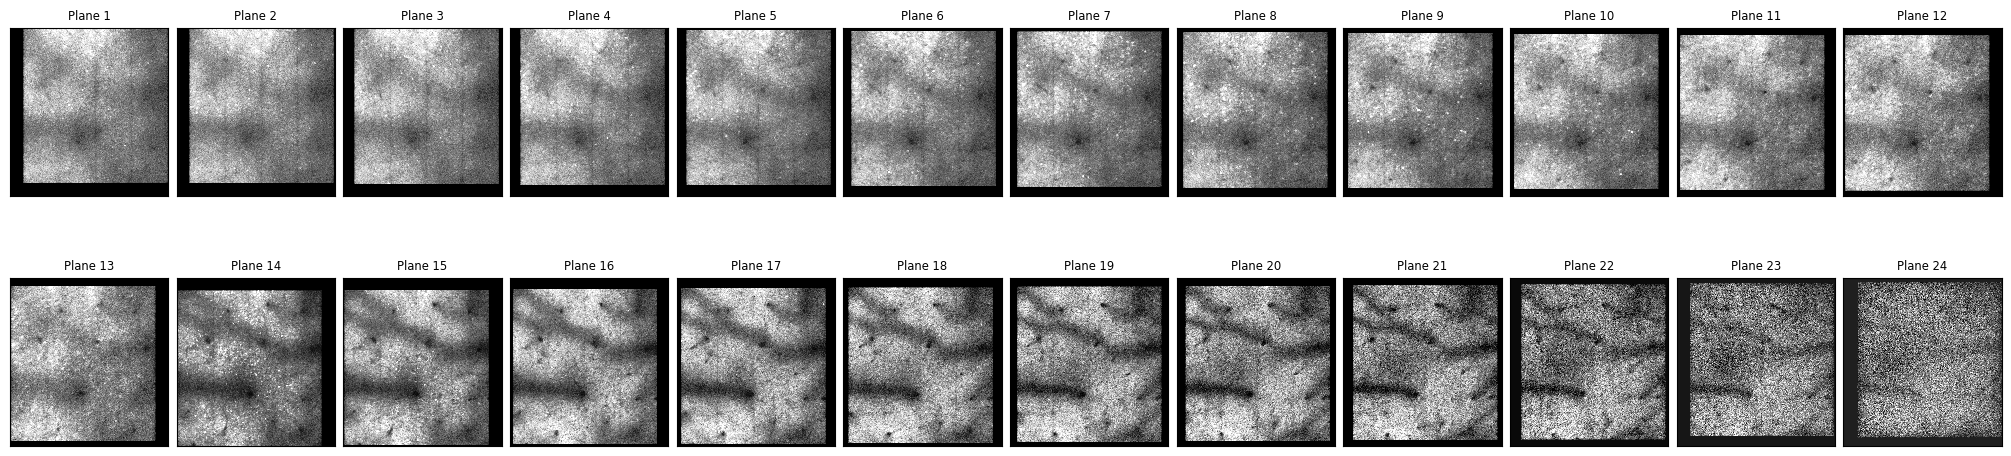

In [10]:
tfu.show_tif_all_planes(img3d, ncols=12, figsize=(20,5))

In [11]:
# nbui.ImageSliceViewer3D(img3d)

In [12]:
# %%time
# job.register(tifs=job.tifs)

In [13]:
# mov = job.get_registered_movie()

In [187]:
# %%time
# job.params['voxel_size_um'] = (20, 2.5, 2.5)
# job.params['npil_filt_type'] = 'unif'
# job.params['npil_filt_xy_um'] = 200

# job.params['cell_filt_type'] = 'gaussian'
# job.params['cell_filt_xy_um'] = 5
# job.params['sdnorm_exp'] = 0.85
# # job.params['intensity_thresh'] = 1.0 # original run with 0.1
# corr_map = job.calculate_corr_map()

In [15]:
corr_map = job.load_corr_map_results()['vmap']

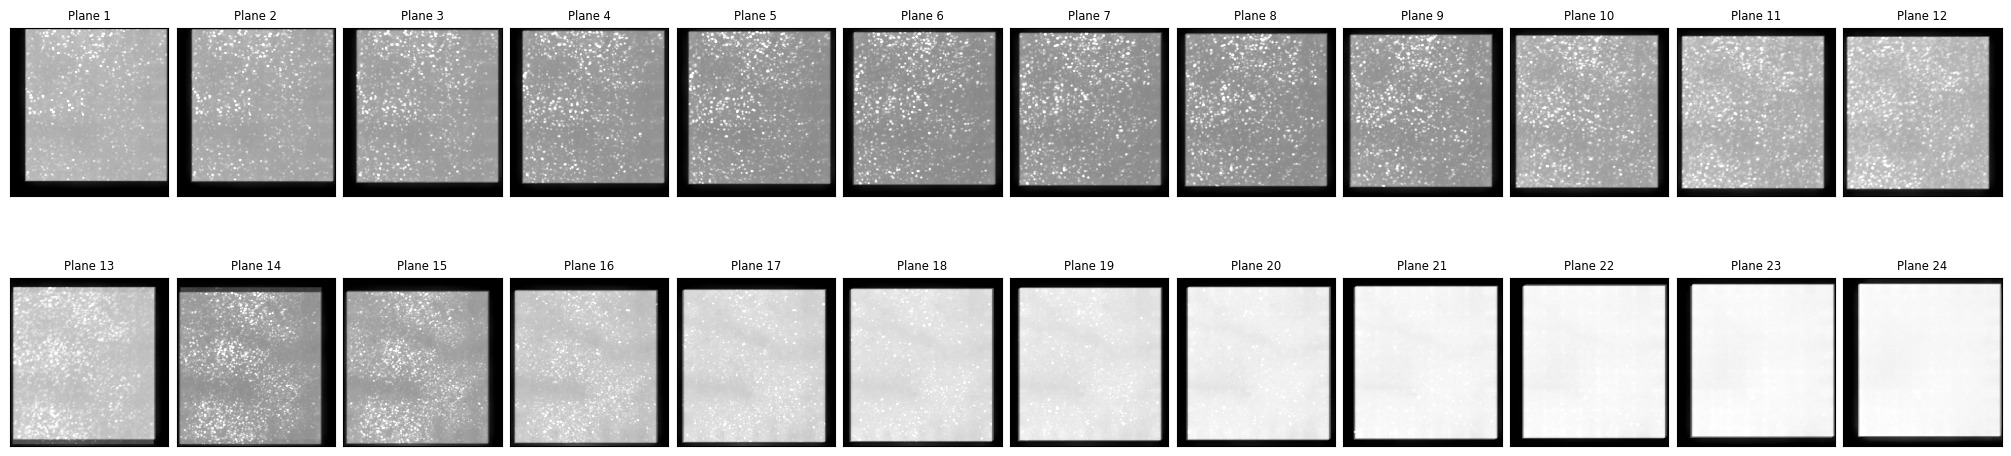

In [16]:
tfu.show_tif_all_planes(corr_map, ncols=12, figsize=(20,5))

In [97]:
from skimage.filters import threshold_multiotsu
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola, threshold_local

In [314]:
corr_map = job.load_corr_map_results()['vmap']

In [315]:

corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 50)

Text(0.5, 1.0, 'Old Correlation Map')

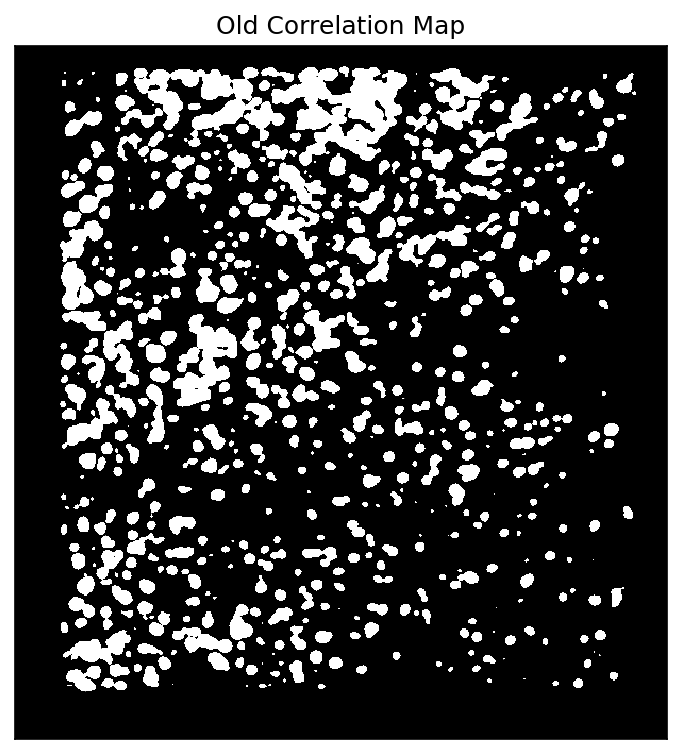

In [316]:
tfu.show_tif(corr_map[5], vminmax=(0.471,0.4711))
plt.title("Old Correlation Map")

Text(0.5, 1.0, 'New Correlation Map')

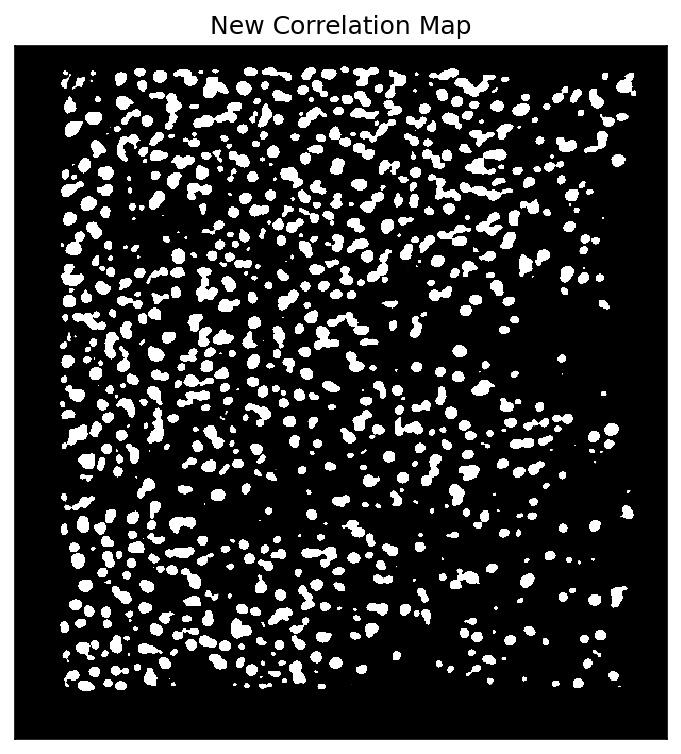

In [317]:
tfu.show_tif(corr_map_thresh[5], vminmax=(0.03, 0.031))
plt.title("New Correlation Map")

In [232]:
from suite3d import extension as ext

In [319]:
job.get_dir_frame_idxs('2')

(5467, 10140)

In [265]:
%%time
job.params['peak_thresh'] = 0.02
# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.0

job.params['extend_thresh'] = 0.05
job.params['activity_thresh'] = 5.0
job.params['max_iter'] = 1000
job.params['ext_subtract_iters'] = 3
job.params['n_proc_detect'] = 32

# corr_map = job.load_corr_map_results()['vmap']
job.segment_rois(vmap=thresh_corrmap, ts = ()

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/segmentation and /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois 
dict_keys(['vmap', 'all_params'])
   Detecting from patch 1 / 49
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/segmentation/patch-0000
         Loading 21.63 GB movie to memory, shape: (16800, 24, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.020 and Th2: 5.000
         Iter 0000: running 32 ROIs in parallel
         Added cell 1 at 09, 039, 093, peak: 0.711, thresh: 5.000, 2611 frames, 294 pixels
         Added cell 2 at 04, 028, 100, pea

'/mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois'

In [270]:
seg['info'].keys()

dict_keys(['vmap', 'all_params'])

In [268]:
seg = job.load_segmentation_results()
shape = seg['info']['vmap'].shape
cell_id_vol, rgb_vol = ui.make_label_vols(seg['stats'], shape, lam_max=0.1, cmap='Set1')
nbui.ImageSliceViewer3D(thresh_corrmap,cmap='Greys',vminmax=(.02,0.1), overlay=rgb_vol, alpha=1.0)

      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois/info.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois/iscell.npy


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [283]:
cmap_res = job.load_corr_map_results()

In [284]:
cmap_res.keys()

dict_keys(['max_img', 'mean_img', 'vmap'])

In [274]:
infopath = '/mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-16_1-2-3-4/info.npy'

In [279]:
info = n.load(infopath, allow_pickle=True).item()

In [285]:
info['max_img'] = cmap_res['max_img']
info['mean_img'] = cmap_res['mean_img']

In [286]:
n.save(infopath, info)

In [273]:
# job.compute_npil_masks(stats_dir = job.dirs['rois'])



# traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])

job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois', additiona_info = job.load_corr_map_results()a)

   Created dir /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-16_1-2-3-4 to export results
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois/stats_small.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois/info.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois/F.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois/spks.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois/Fneu.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4/rois/iscell.npy
      Overwriting existing /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-16_1-2-3-4/s3d-params.npy
      Overwriting existing /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-16_1-2-3-4/frames.npy
      Overwriting existing /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-16_1-2-3-4/stats.npy
      Saved stats.npy to /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-16_1-2-3-4
      Overwriting existing /mnt/zeytin-f1/s

In [ ]:
# tfu.show_tif_all_planes(masked_imgs, ncols=12, figsize=(20,5), same_scale=True, vminmax=(0.03, 0.031))


# img = corr_map[-1].copy()
# for window_size in (5,11,21,31, 41, 71, 101, 201):
#     thresh_otsu = threshold_otsu(img)
#     # window_size = 11
#     thresh_niblack = threshold_niblack(img, window_size=window_size, k=0.1)
#     # thresh_sauvola = threshold_sauvola(img, window_size=51)
#     thresh_local = threshold_local(img, block_size=window_size)
    
#     masked_img_local = img.copy()
#     masked_img_local[img < thresh_local] = img.min()
#     masked_img_otsu = img.copy()
#     masked_img_otsu[img < thresh_otsu] = img.min()
#     masked_img_niblack = img.copy()
#     masked_img_niblack[img < thresh_niblack] = img.min()
    
#     f,axs = plt.subplots(2,3,figsize=(15,10),layout='constrained')
#     tfu.show_tif((img > thresh_otsu).astype(int),ax=axs[0][0])
#     tfu.show_tif((img > thresh_niblack).astype(int),ax=axs[0][1])
#     tfu.show_tif((img > thresh_local).astype(int),ax=axs[0][2])
    
#     tfu.show_tif(masked_img_otsu,ax=axs[1][0], vminmax_percentile = (75,95))
#     tfu.show_tif(masked_img_niblack,ax=axs[1][1], vminmax_percentile = (75,95))
#     tfu.show_tif(masked_img_local,ax=axs[1][2], vminmax_percentile = (75,95))

#     plt.suptitle(window_size)
#     plt.show()

# bins = n.linspace(*minmax, 101)
# plt.hist(corr_map_f[0], bins=bins, log=True,histtype='step')
# plt.hist(corr_map_f[5], bins=bins, log=True,histtype='step')
# plt.hist(corr_map_f[10], bins=bins, log=True,histtype='step')
# plt.hist(corr_map_f[15], bins=bins, log=True,histtype='step')
# plt.hist(corr_map_f[20], bins=bins, log=True,histtype='step')

In [322]:
job.get_dir_frame_idxs('2')

(5467, 10140)

In [330]:
roi_idx = 6826


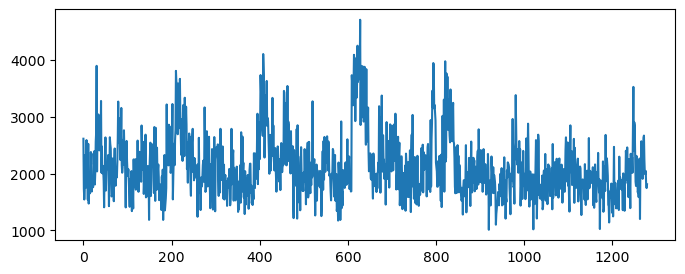

In [331]:
plt.figure(figsize=(8,3))
plt.plot(traces['F'][roi_idx][:320*4])

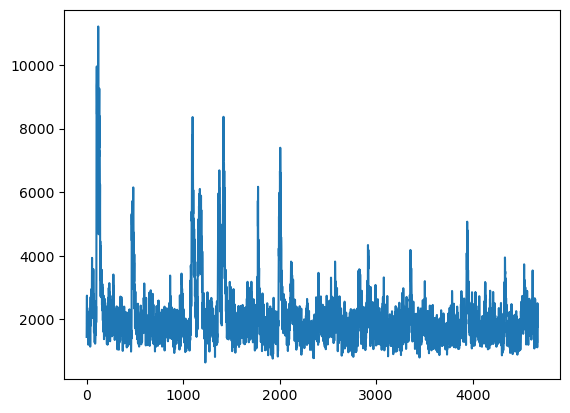

In [332]:

plt.plot(traces['F'][roi_idx][5467:10140])